**IMPLEMENTATION WITHOUT PHYSICAL CONSTRAINTS**

Plots will be saved to 'plots_without_constraints' directory.
--- 1. Data Loading and Preparation ---
Dataset size: 2447 samples with 30 features.
--- 2. Data Splitting and Scaling ---
Training set size: 1957, Test set size: 490

RUNNING: Model without Physical Constraints

--- 3. Optimizing Hyperparameters with Optuna ---


/tmp/ipython-input-4193190864.py:78: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/100 [00:00<?, ?it/s]


--- 4. Training Final Model ---

--- 5. Model Performance Evaluation ---

--- Test Set ---
R²: 0.5536  |  MAE: 10.5944 m  |  RMSE: 15.3909 m

--- 6. Feature Importance Analysis ---

--- 7. Generating Visualizations ---
Could not save Optuna plot. Error: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



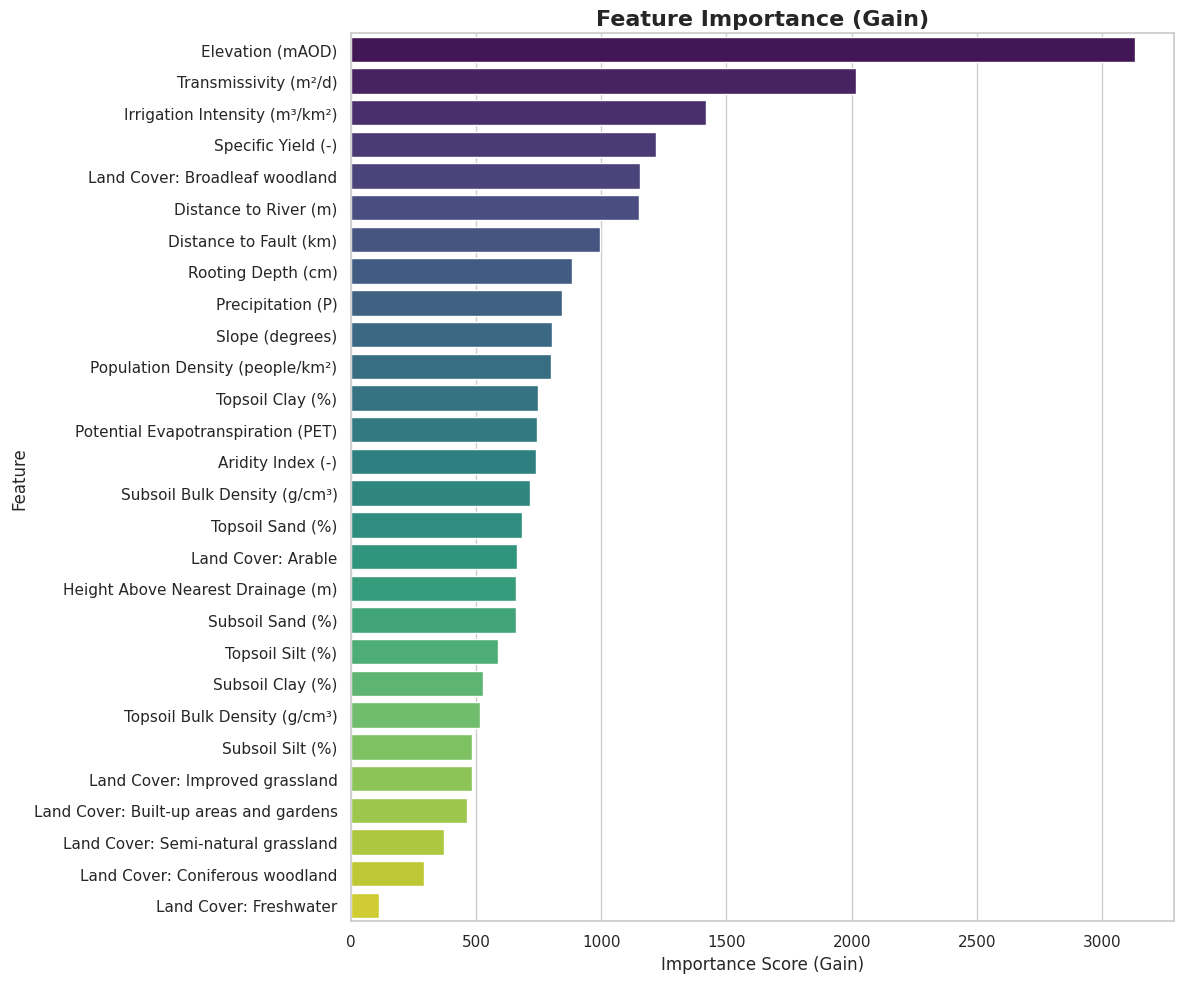

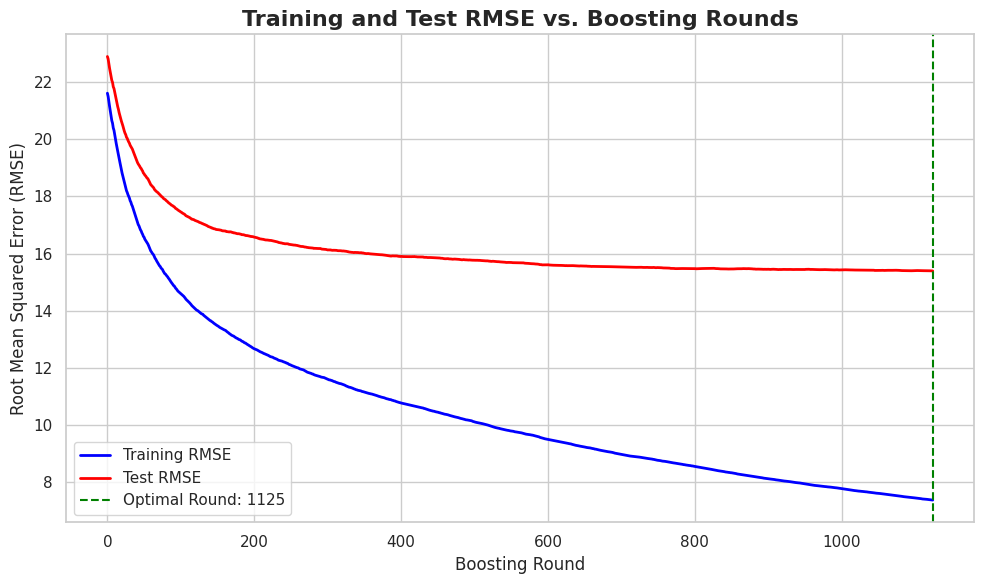

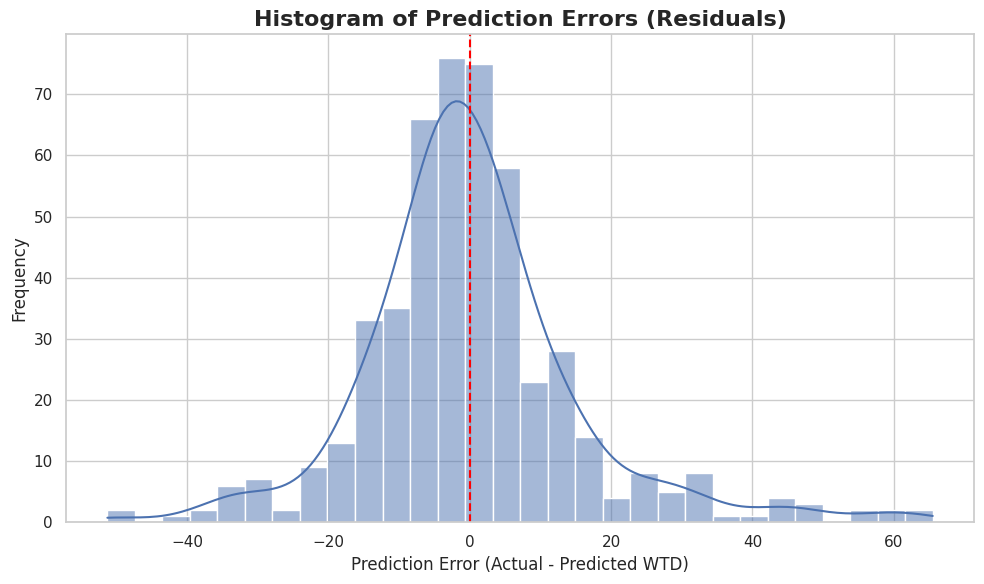

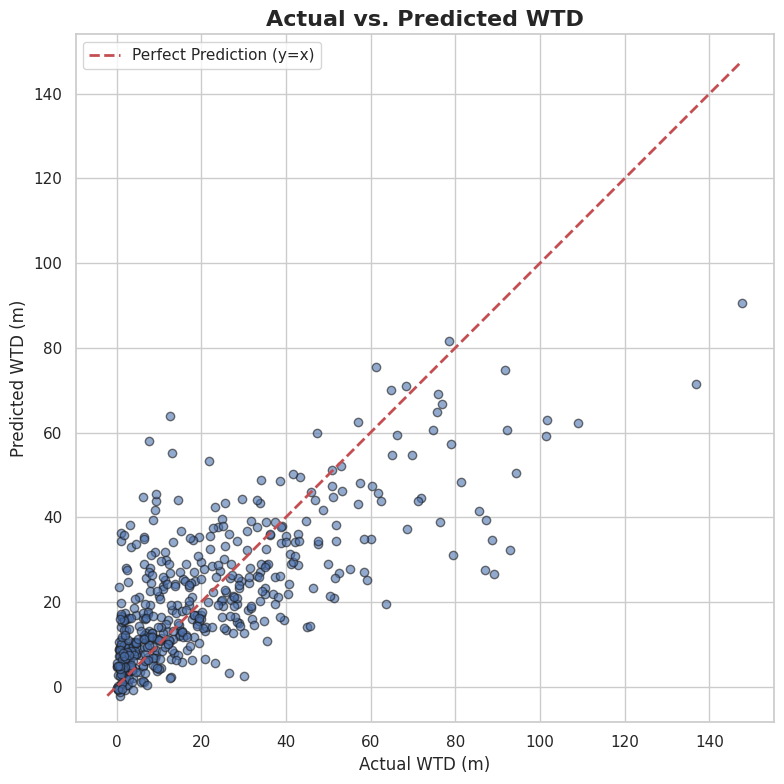


--- 8. Generating Spatial Error Map ---


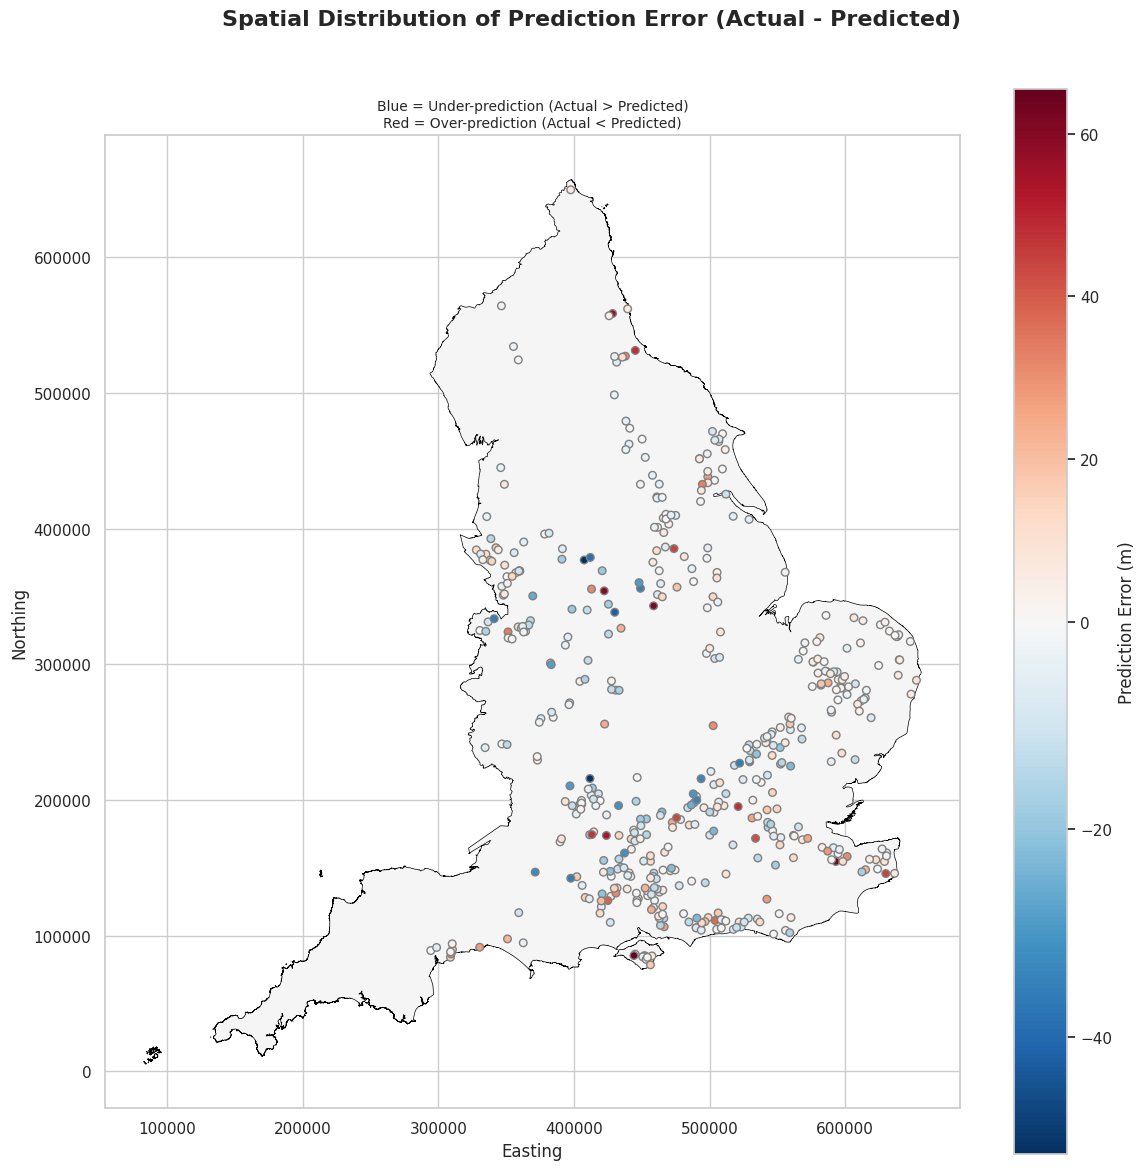


Analysis completed successfully!


In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import sys
import warnings
import os

# Data processing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from optuna.visualization import plot_optimization_history

# Spatial mapping libraries
import geopandas as gpd
from shapely.geometry import Point

# --- SETUP ---
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="whitegrid")

# Create a directory to save plots
output_dir_unconstrained = 'plots_without_constraints'
os.makedirs(output_dir_unconstrained, exist_ok=True)
print(f"Plots will be saved to '{output_dir_unconstrained}' directory.")


# --- DATA LOADING AND PREPARATION ---
print("--- 1. Data Loading and Preparation ---")
try:
    df = pd.read_csv('/content/final_station_data_with_aridity.csv')
except FileNotFoundError:
    print("Error: The file 'final_station_data_with_aridity.csv' was not found.")
    sys.exit(1)

numerical_features_original = [
    'Elevation', 'Slope', 'Dep_R', 'Population density_5km circle averaged',
    'Irrigation intensity', 'distance to river (m)', 'Aridity_Index', 'T_Sand',
    'S_Sand', 'Hand', 'Estimated T (m2d-1)', 'mean_P', 'T_Clay', 'S_Clay',
    'T_Silt', 'S_Silt', 'mean_PET', 'T_BD', 'S_BD', 'Sy (-)', 'Sdf (km)'
]
categorical_features = ['LC_2015']

df_encoded = pd.get_dummies(df, columns=categorical_features, prefix='Land Cover')
lc_map = {
    1: 'Land Cover: Broadleaf woodland', 2: 'Land Cover: Coniferous woodland', 3: 'Land Cover: Arable',
    4: 'Land Cover: Improved grassland', 5: 'Land Cover: Semi-natural grassland',
    6: 'Land Cover: Mountain, heath, bog', 7: 'Land Cover: Saltwater', 8: 'Land Cover: Freshwater',
    9: 'Land Cover: Coastal', 10: 'Land Cover: Built-up areas and gardens'
}
rename_dict = {f'Land Cover_{code}': name for code, name in lc_map.items()}
df_encoded.rename(columns=rename_dict, inplace=True)
encoded_feature_names = [name for name in rename_dict.values() if name in df_encoded.columns]

all_features_original = numerical_features_original + encoded_feature_names
X = df_encoded[all_features_original]
y = df_encoded['mean_GD']
station_indices = df_encoded.index

label_mapping = {
    'mean_P': 'Precipitation (P)', 'mean_PET': 'Potential Evapotranspiration (PET)', 'Elevation': 'Elevation (mAOD)',
    'T_Sand': 'Topsoil Sand (%)', 'T_Silt': 'Topsoil Silt (%)', 'T_Clay': 'Topsoil Clay (%)',
    'T_BD': 'Topsoil Bulk Density (g/cm³)', 'S_Sand': 'Subsoil Sand (%)', 'S_Silt': 'Subsoil Silt (%)',
    'S_Clay': 'Subsoil Clay (%)', 'S_BD': 'Subsoil Bulk Density (g/cm³)', 'Dep_R': 'Rooting Depth (cm)',
    'Sdf (km)': 'Distance to Fault (km)', 'Estimated T (m2d-1)': 'Transmissivity (m²/d)', 'Sy (-)': 'Specific Yield (-)',
    'Population density_5km circle averaged': 'Population Density (people/km²)', 'Irrigation intensity': 'Irrigation Intensity (m³/km²)',
    'Hand': 'Height Above Nearest Drainage (m)', 'distance to river (m)': 'Distance to River (m)',
    'Slope': 'Slope (degrees)', 'Aridity_Index': 'Aridity Index (-)'
}

X.rename(columns=label_mapping, inplace=True)
numerical_features = [label_mapping.get(f, f) for f in numerical_features_original]
all_features = [label_mapping.get(f, f) for f in all_features_original]

print(f"Dataset size: {X.shape[0]} samples with {len(all_features)} features.")

# --- DATA SPLITTING AND SCALING ---
print("--- 2. Data Splitting and Scaling ---")
y_bins = pd.qcut(y, q=5, labels=False, duplicates='drop')
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, station_indices, test_size=0.2, random_state=42, stratify=y_bins
)
scaler = RobustScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# --- HYPERPARAMETER OPTIMIZATION ---
print("\n" + "="*60)
print("RUNNING: Model without Physical Constraints")
print("="*60)

def objective(trial):
    params = {
        'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'tree_method': 'hist', 'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 4),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 100.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 100.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0, 20.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 30),
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    cv_results = xgb.cv(
        params=params, dtrain=dtrain, num_boost_round=1000, nfold=5,
        metrics='rmse', early_stopping_rounds=50, verbose_eval=False, seed=42
    )
    return cv_results['test-rmse-mean'].min()

print("\n--- 3. Optimizing Hyperparameters with Optuna ---")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# --- FINAL MODEL TRAINING ---
print("\n--- 4. Training Final Model ---")
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=all_features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=all_features)
final_params = {
    'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'tree_method': 'hist', 'random_state': 42
}
final_params.update(study.best_params)
cv_results = xgb.cv(
    params=final_params, dtrain=dtrain, num_boost_round=2000, nfold=5,
    metrics='rmse', early_stopping_rounds=50, verbose_eval=False, seed=42
)
best_rounds = cv_results['test-rmse-mean'].idxmin() + 1
if best_rounds > 1500: best_rounds = 1500
evals_result = {}
model = xgb.train(
    params=final_params, dtrain=dtrain, num_boost_round=best_rounds,
    evals=[(dtrain, 'train'), (dtest, 'test')], evals_result=evals_result, verbose_eval=False
)

# --- MODEL EVALUATION ---
print("\n--- 5. Model Performance Evaluation ---")
test_preds = model.predict(dtest)
test_r2 = r2_score(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print("\n--- Test Set ---")
print(f"R²: {test_r2:.4f}  |  MAE: {test_mae:.4f} m  |  RMSE: {test_rmse:.4f} m")

# --- FEATURE IMPORTANCE ---
print("\n--- 6. Feature Importance Analysis ---")
importance_scores = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_scores.keys()),
    'Importance (Gain)': list(importance_scores.values())
}).sort_values(by='Importance (Gain)', ascending=False)

# --- PLOTS AND VISUALIZATIONS ---
print("\n--- 7. Generating Visualizations ---")

# Plot 1: Optuna optimization history
try:
    fig_optuna = plot_optimization_history(study)
    fig_optuna.update_layout(title_text="Optuna Optimization History", title_x=0.5)
    fig_optuna.write_image(os.path.join(output_dir_unconstrained, '1_optuna_history.pdf'))
    fig_optuna.show()
except Exception as e:
    print(f"Could not save Optuna plot. Error: {e}")

# Plot 2: Feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance (Gain)', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (Gain)', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir_unconstrained, '2_feature_importance.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# Plot 3: Training and test RMSE
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['rmse'], label='Training RMSE', color='blue', linewidth=2)
plt.plot(evals_result['test']['rmse'], label='Test RMSE', color='red', linewidth=2)
plt.axvline(x=best_rounds, color='green', linestyle='--', label=f'Optimal Round: {best_rounds}')
plt.title('Training and Test RMSE vs. Boosting Rounds', fontsize=16, fontweight='bold')
plt.xlabel('Boosting Round', fontsize=12)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir_unconstrained, '3_rmse_vs_rounds.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# Plot 4: Histogram of Residuals
residuals = y_test - test_preds
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Histogram of Prediction Errors (Residuals)', fontsize=16, fontweight='bold')
plt.xlabel('Prediction Error (Actual - Predicted WTD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir_unconstrained, '4_residuals_histogram.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# Plot 5: Scatter Plot of Actual vs. Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test, test_preds, alpha=0.6, edgecolors='k')
max_val = max(y_test.max(), test_preds.max())
min_val = min(y_test.min(), test_preds.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')
plt.title('Actual vs. Predicted WTD', fontsize=16, fontweight='bold')
plt.xlabel('Actual WTD (m)', fontsize=12)
plt.ylabel('Predicted WTD (m)', fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.savefig(os.path.join(output_dir_unconstrained, '5_actual_vs_predicted.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# --- SPATIAL ERROR MAPPING ---
print("\n--- 8. Generating Spatial Error Map ---")
england_shapefile_path = '/content/England.shp'
try:
    england_map = gpd.read_file(england_shapefile_path)
    results_df = pd.DataFrame({'Station_ID': test_indices, 'Actual_WTD': y_test.values, 'Predicted_WTD': test_preds})
    results_df['Difference'] = results_df['Actual_WTD'] - results_df['Predicted_WTD']
    test_station_coords = df.loc[test_indices][['long', 'lat']]
    merged_geo_results = pd.merge(results_df, test_station_coords, left_on='Station_ID', right_index=True)
    geometry = [Point(xy) for xy in zip(merged_geo_results['long'], merged_geo_results['lat'])]
    geo_results_gdf = gpd.GeoDataFrame(merged_geo_results, geometry=geometry, crs="EPSG:4326").to_crs(england_map.crs)

    div_norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=geo_results_gdf['Difference'].min(), vmax=geo_results_gdf['Difference'].max())
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    fig.suptitle('Spatial Distribution of Prediction Error (Actual - Predicted)', fontsize=16, fontweight='bold')
    england_map.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=0.5)
    geo_results_gdf.plot(column='Difference', ax=ax, legend=True, markersize=30, cmap='RdBu_r', edgecolor='grey', norm=div_norm,
                         legend_kwds={'label': "Prediction Error (m)", 'orientation': "vertical"})
    ax.set_title('Blue = Under-prediction (Actual > Predicted)\nRed = Over-prediction (Actual < Predicted)', fontsize=10)
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(os.path.join(output_dir_unconstrained, '6_spatial_error_map.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)
except FileNotFoundError:
    print(f"Shapefile not found at '{england_shapefile_path}'. Skipping spatial map.")
except Exception as e:
    print(f"An error occurred during mapping: {e}")

print("\n" + "="*60)
print("Analysis completed successfully!")
print("="*60)

**IMPLEMENTATION WITH PHYSICAL CONSTRAINTS**

Plots will be saved to 'plots_with_constraints' directory.
--- 1. Data Loading and Preparation ---
Dataset size: 2447 samples with 30 features.
--- 2. Data Splitting and Scaling ---
Training set size: 1957, Test set size: 490

RUNNING: Model with Physical Constraints

--- 3. Optimizing Hyperparameters with Optuna ---


/tmp/ipython-input-1122477064.py:77: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/100 [00:00<?, ?it/s]


--- 4. Training Final Model ---

--- 5. Model Performance Evaluation ---

--- Test Set ---
R²: 0.5765  |  MAE: 10.4673 m  |  RMSE: 14.9912 m

--- 6. Feature Importance Analysis ---

--- 7. Generating Visualizations ---
Could not save Optuna plot. Error: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



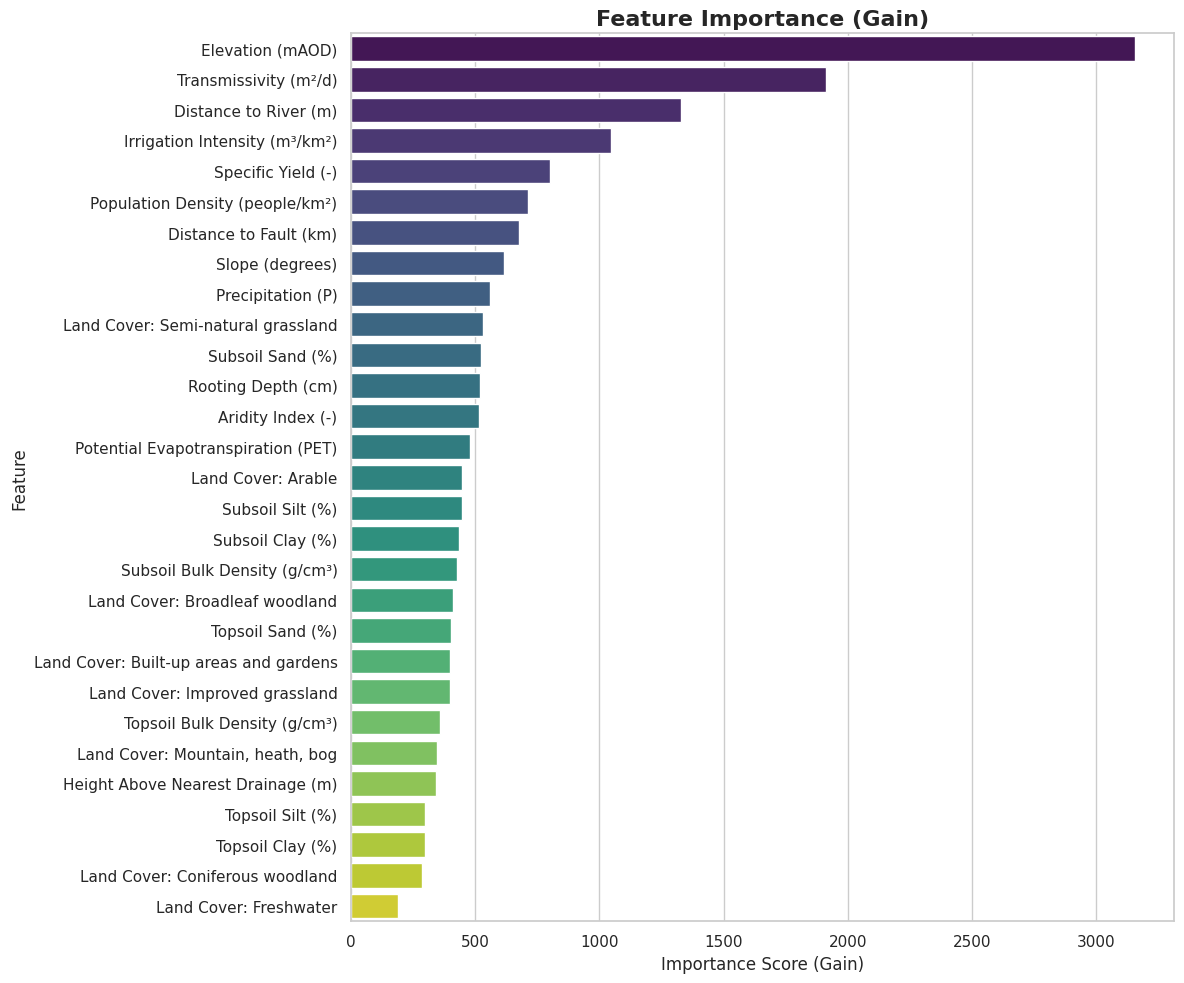

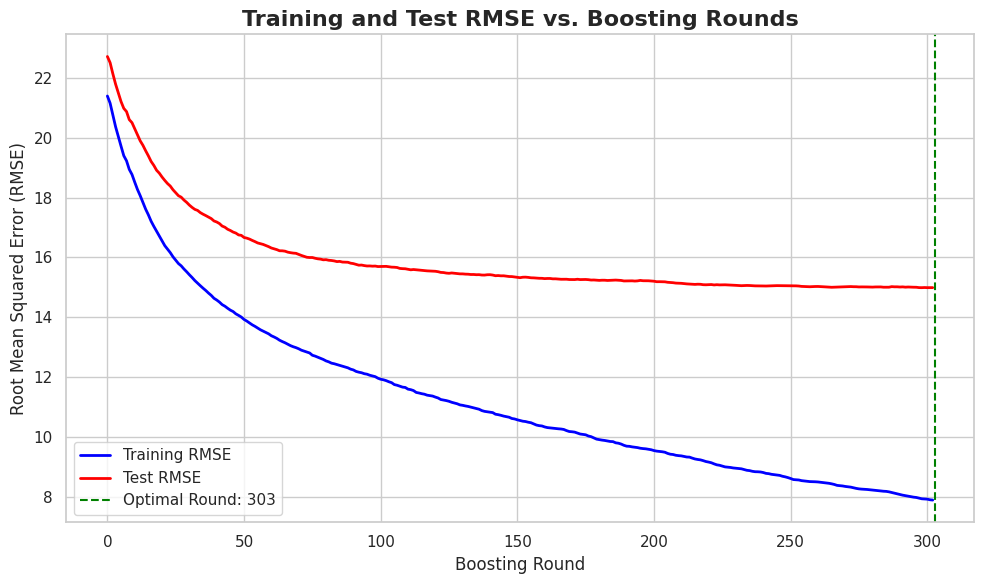

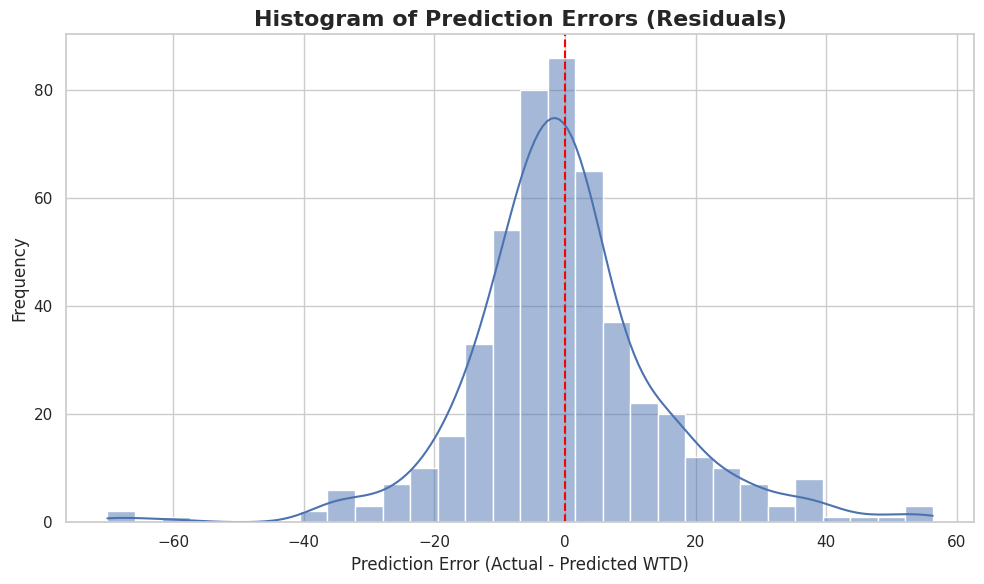

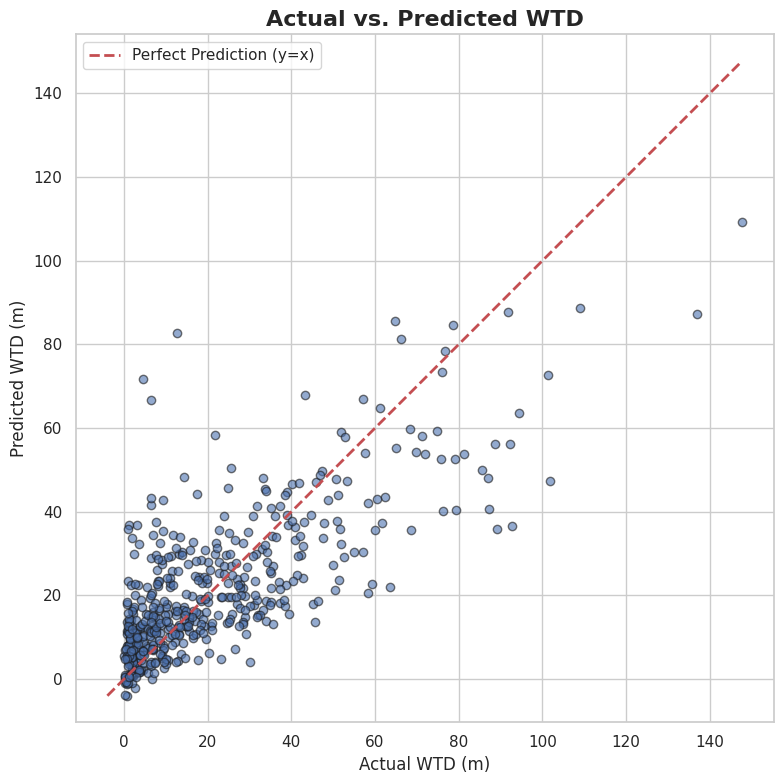


--- 8. Generating Spatial Error Map ---


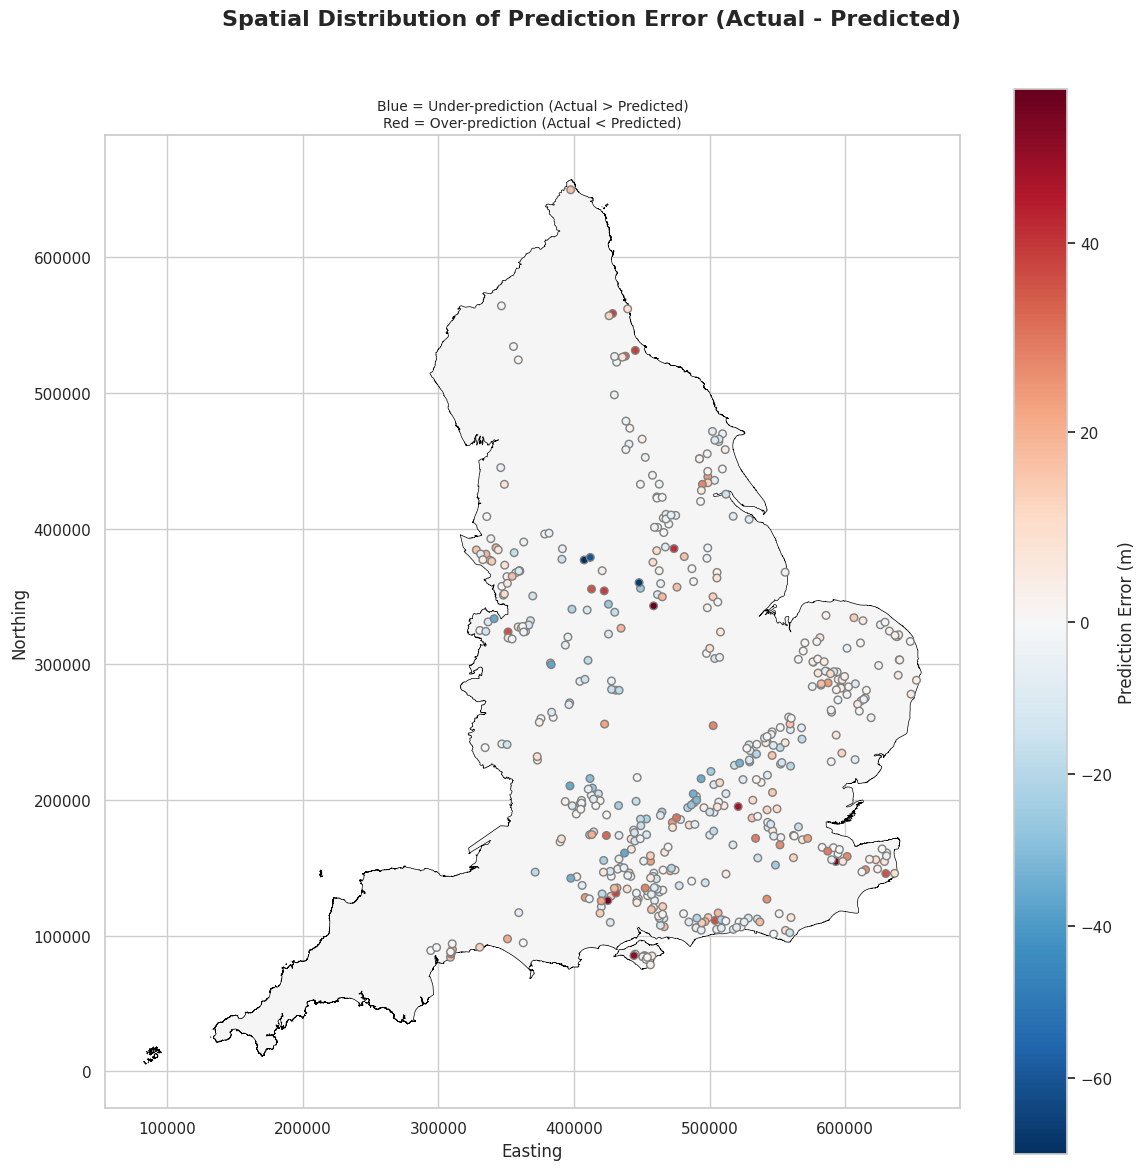


Analysis completed successfully!


In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import sys
import warnings
import os

# Data processing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from optuna.visualization import plot_optimization_history

# Spatial mapping libraries
import geopandas as gpd
from shapely.geometry import Point

# --- SETUP ---
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="whitegrid")

# Create a directory to save plots
output_dir_constrained = 'plots_with_constraints'
os.makedirs(output_dir_constrained, exist_ok=True)
print(f"Plots will be saved to '{output_dir_constrained}' directory.")

# --- DATA LOADING AND PREPARATION ---
print("--- 1. Data Loading and Preparation ---")
try:
    df = pd.read_csv('/content/final_station_data_with_aridity.csv')
except FileNotFoundError:
    print("Error: The file 'final_station_data_with_aridity.csv' was not found.")
    sys.exit(1)

numerical_features_original = [
    'Elevation', 'Slope', 'Dep_R', 'Population density_5km circle averaged',
    'Irrigation intensity', 'distance to river (m)', 'Aridity_Index', 'T_Sand',
    'S_Sand', 'Hand', 'Estimated T (m2d-1)', 'mean_P', 'T_Clay', 'S_Clay',
    'T_Silt', 'S_Silt', 'mean_PET', 'T_BD', 'S_BD', 'Sy (-)', 'Sdf (km)'
]
categorical_features = ['LC_2015']

df_encoded = pd.get_dummies(df, columns=categorical_features, prefix='Land Cover')
lc_map = {
    1: 'Land Cover: Broadleaf woodland', 2: 'Land Cover: Coniferous woodland', 3: 'Land Cover: Arable',
    4: 'Land Cover: Improved grassland', 5: 'Land Cover: Semi-natural grassland',
    6: 'Land Cover: Mountain, heath, bog', 7: 'Land Cover: Saltwater', 8: 'Land Cover: Freshwater',
    9: 'Land Cover: Coastal', 10: 'Land Cover: Built-up areas and gardens'
}
rename_dict = {f'Land Cover_{code}': name for code, name in lc_map.items()}
df_encoded.rename(columns=rename_dict, inplace=True)
encoded_feature_names = [name for name in rename_dict.values() if name in df_encoded.columns]

all_features_original = numerical_features_original + encoded_feature_names
X = df_encoded[all_features_original]
y = df_encoded['mean_GD']
station_indices = df_encoded.index

label_mapping = {
    'mean_P': 'Precipitation (P)', 'mean_PET': 'Potential Evapotranspiration (PET)', 'Elevation': 'Elevation (mAOD)',
    'T_Sand': 'Topsoil Sand (%)', 'T_Silt': 'Topsoil Silt (%)', 'T_Clay': 'Topsoil Clay (%)',
    'T_BD': 'Topsoil Bulk Density (g/cm³)', 'S_Sand': 'Subsoil Sand (%)', 'S_Silt': 'Subsoil Silt (%)',
    'S_Clay': 'Subsoil Clay (%)', 'S_BD': 'Subsoil Bulk Density (g/cm³)', 'Dep_R': 'Rooting Depth (cm)',
    'Sdf (km)': 'Distance to Fault (km)', 'Estimated T (m2d-1)': 'Transmissivity (m²/d)', 'Sy (-)': 'Specific Yield (-)',
    'Population density_5km circle averaged': 'Population Density (people/km²)', 'Irrigation intensity': 'Irrigation Intensity (m³/km²)',
    'Hand': 'Height Above Nearest Drainage (m)', 'distance to river (m)': 'Distance to River (m)',
    'Slope': 'Slope (degrees)', 'Aridity_Index': 'Aridity Index (-)'
}

X.rename(columns=label_mapping, inplace=True)
numerical_features = [label_mapping.get(f, f) for f in numerical_features_original]
all_features = [label_mapping.get(f, f) for f in all_features_original]

print(f"Dataset size: {X.shape[0]} samples with {len(all_features)} features.")

# --- DATA SPLITTING AND SCALING ---
print("--- 2. Data Splitting and Scaling ---")
y_bins = pd.qcut(y, q=5, labels=False, duplicates='drop')
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, station_indices, test_size=0.2, random_state=42, stratify=y_bins
)
scaler = RobustScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# --- HYPERPARAMETER OPTIMIZATION ---
print("\n" + "="*60)
print("RUNNING: Model with Physical Constraints")
print("="*60)
monotonic_constraints_dict = {
    'Aridity Index (-)': 1, 'Topsoil Sand (%)': 1, 'Subsoil Sand (%)': 1,
    'Height Above Nearest Drainage (m)': 1, 'Transmissivity (m²/d)': 1,
    'Topsoil Clay (%)': -1, 'Subsoil Clay (%)': -1, 'Elevation (mAOD)': 1,
    'Distance to River (m)': 1, 'Irrigation Intensity (m³/km²)': 1,
    'Population Density (people/km²)': 1, 'Slope (degrees)': 1,
    'Topsoil Bulk Density (g/cm³)': -1, 'Subsoil Bulk Density (g/cm³)': -1
}
monotonic_constraints = [monotonic_constraints_dict.get(f, 0) for f in all_features]

def objective(trial):
    params = {
        'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'tree_method': 'hist', 'random_state': 42,
        'monotone_constraints': '(' + ','.join(map(str, monotonic_constraints)) + ')',
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 50.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 50.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0, 20.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    cv_results = xgb.cv(
        params=params, dtrain=dtrain, num_boost_round=1000, nfold=5,
        metrics='rmse', early_stopping_rounds=50, verbose_eval=False, seed=42
    )
    return cv_results['test-rmse-mean'].min()

print("\n--- 3. Optimizing Hyperparameters with Optuna ---")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# --- FINAL MODEL TRAINING ---
print("\n--- 4. Training Final Model ---")
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=all_features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=all_features)
final_params = {
    'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'tree_method': 'hist', 'random_state': 42,
    'monotone_constraints': '(' + ','.join(map(str, monotonic_constraints)) + ')'
}
final_params.update(study.best_params)
cv_results = xgb.cv(
    params=final_params, dtrain=dtrain, num_boost_round=2000, nfold=5,
    metrics='rmse', early_stopping_rounds=50, verbose_eval=False, seed=42
)
best_rounds = cv_results['test-rmse-mean'].idxmin() + 1
if best_rounds > 800: best_rounds = 800
evals_result = {}
model = xgb.train(
    params=final_params, dtrain=dtrain, num_boost_round=best_rounds,
    evals=[(dtrain, 'train'), (dtest, 'test')], evals_result=evals_result, verbose_eval=False
)

# --- MODEL EVALUATION ---
print("\n--- 5. Model Performance Evaluation ---")
test_preds = model.predict(dtest)
test_r2 = r2_score(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print("\n--- Test Set ---")
print(f"R²: {test_r2:.4f}  |  MAE: {test_mae:.4f} m  |  RMSE: {test_rmse:.4f} m")

# --- FEATURE IMPORTANCE ---
print("\n--- 6. Feature Importance Analysis ---")
importance_scores = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_scores.keys()),
    'Importance (Gain)': list(importance_scores.values())
}).sort_values(by='Importance (Gain)', ascending=False)

# --- PLOTS AND VISUALIZATIONS ---
print("\n--- 7. Generating Visualizations ---")

# Plot 1: Optuna optimization history
try:
    fig_optuna = plot_optimization_history(study)
    fig_optuna.update_layout(title_text="Optuna Optimization History", title_x=0.5)
    fig_optuna.write_image(os.path.join(output_dir_constrained, '1_optuna_history.pdf'))
    fig_optuna.show()
except Exception as e:
    print(f"Could not save Optuna plot. Error: {e}")

# Plot 2: Feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance (Gain)', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (Gain)', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir_constrained, '2_feature_importance.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# Plot 3: Training and test RMSE
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['rmse'], label='Training RMSE', color='blue', linewidth=2)
plt.plot(evals_result['test']['rmse'], label='Test RMSE', color='red', linewidth=2)
plt.axvline(x=best_rounds, color='green', linestyle='--', label=f'Optimal Round: {best_rounds}')
plt.title('Training and Test RMSE vs. Boosting Rounds', fontsize=16, fontweight='bold')
plt.xlabel('Boosting Round', fontsize=12)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir_constrained, '3_rmse_vs_rounds.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# Plot 4: Histogram of Residuals
residuals = y_test - test_preds
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Histogram of Prediction Errors (Residuals)', fontsize=16, fontweight='bold')
plt.xlabel('Prediction Error (Actual - Predicted WTD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir_constrained, '4_residuals_histogram.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# Plot 5: Scatter Plot of Actual vs. Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test, test_preds, alpha=0.6, edgecolors='k')
max_val = max(y_test.max(), test_preds.max())
min_val = min(y_test.min(), test_preds.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')
plt.title('Actual vs. Predicted WTD', fontsize=16, fontweight='bold')
plt.xlabel('Actual WTD (m)', fontsize=12)
plt.ylabel('Predicted WTD (m)', fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.savefig(os.path.join(output_dir_constrained, '5_actual_vs_predicted.pdf'), format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# --- SPATIAL ERROR MAPPING ---
print("\n--- 8. Generating Spatial Error Map ---")
england_shapefile_path = '/content/England.shp'
try:
    england_map = gpd.read_file(england_shapefile_path)
    results_df = pd.DataFrame({'Station_ID': test_indices, 'Actual_WTD': y_test.values, 'Predicted_WTD': test_preds})
    results_df['Difference'] = results_df['Actual_WTD'] - results_df['Predicted_WTD']
    test_station_coords = df.loc[test_indices][['long', 'lat']]
    merged_geo_results = pd.merge(results_df, test_station_coords, left_on='Station_ID', right_index=True)
    geometry = [Point(xy) for xy in zip(merged_geo_results['long'], merged_geo_results['lat'])]
    geo_results_gdf = gpd.GeoDataFrame(merged_geo_results, geometry=geometry, crs="EPSG:4326").to_crs(england_map.crs)

    div_norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=geo_results_gdf['Difference'].min(), vmax=geo_results_gdf['Difference'].max())
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    fig.suptitle('Spatial Distribution of Prediction Error (Actual - Predicted)', fontsize=16, fontweight='bold')
    england_map.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=0.5)
    geo_results_gdf.plot(column='Difference', ax=ax, legend=True, markersize=30, cmap='RdBu_r', edgecolor='grey', norm=div_norm,
                         legend_kwds={'label': "Prediction Error (m)", 'orientation': "vertical"})
    ax.set_title('Blue = Under-prediction (Actual > Predicted)\nRed = Over-prediction (Actual < Predicted)', fontsize=10)
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(os.path.join(output_dir_constrained, '6_spatial_error_map.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)
except FileNotFoundError:
    print(f"Shapefile not found at '{england_shapefile_path}'. Skipping spatial map.")
except Exception as e:
    print(f"An error occurred during mapping: {e}")

print("\n" + "="*60)
print("Analysis completed successfully!")
print("="*60)

**PLOTS**

In [8]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import os

def generate_geospatial_plots(csv_filepath, shapefile_path, output_dir='geospatial_plots'):
    """
    Loads geospatial data, generates plots for specified variables, and saves them
    as high-resolution PDF files.

    Args:
        csv_filepath (str): The path to the input CSV data file.
        shapefile_path (str): The path to the .shp file for the map boundary.
        output_dir (str): The directory where plot images will be saved.
    """
    try:
        # Ensure the output directory exists.
        os.makedirs(output_dir, exist_ok=True)

        # Load the station data from the CSV file.
        if not os.path.exists(csv_filepath):
            raise FileNotFoundError(f"Data file not found at '{csv_filepath}'")
        df = pd.read_csv(csv_filepath)

        # Define metadata for plotting variables.
        variable_metadata = {
            'Elevation': {'name': 'Elevation', 'unit': 'm'},
            'Slope': {'name': 'Slope', 'unit': 'degrees'},
            'Population density_5km circle averaged': {'name': 'Population Density (5km Avg)', 'unit': 'persons/km²'},
            'Irrigation intensity': {'name': 'Irrigation Intensity', 'unit': 'unitless index'},
            'distance to river (m)': {'name': 'Distance to River', 'unit': 'm'},
            'Hand': {'name': 'Height Above Nearest Drainage', 'unit': 'm'},
            'Dep_R': {'name': 'Depth to Roots', 'unit': 'cm'},
            'T_BD': {'name': 'Topsoil Bulk Density', 'unit': 'g/cm³'},
            'S_BD': {'name': 'Subsoil Bulk Density', 'unit': 'g/cm³'},
            'Estimated T (m2d-1)': {'name': 'Estimated Transmissivity', 'unit': 'm²/d'},
            'Sy (-)': {'name': 'Estimated Specific Yield', 'unit': 'dimensionless'},
            'Sdf (km)': {'name': 'Shortest Distance to Fault', 'unit': 'km'},
            'mean_P': {'name': 'Mean Precipitation', 'unit': 'mm/day'},
            'mean_PET': {'name': 'Mean Potential Evapotranspiration', 'unit': 'mm/day'},
            'mean_Water_Table_Depth': {'name': 'Mean Water Table Depth', 'unit': 'm'},
            'Aridity_Index': {'name': 'Aridity Index', 'unit': 'dimensionless'},
            'LEX_D': {'name': 'Dominant Geology', 'unit': ''} # Categorical
        }

        # Preprocess the dataframe.
        df.rename(columns={'mean_GD': 'mean_Water_Table_Depth'}, inplace=True)

        columns_to_drop = [
            'years_used', 'P_PET_records_used', 'GD_records_used',
            'years_with_data', 'Confined aquifers'
        ] + [col for col in df.columns if 'LC_' in col]

        df = df.drop(columns=columns_to_drop, errors='ignore')
        df.dropna(subset=['lat', 'long'], inplace=True)

        # Load the map boundary shapefile.
        if not os.path.exists(shapefile_path):
            raise FileNotFoundError(f"Shapefile not found at '{shapefile_path}'")
        england_map = geopandas.read_file(shapefile_path)

        # Prepare data for plotting.
        plot_columns = [col for col in variable_metadata.keys() if col in df.columns]

        gdf_stations = geopandas.GeoDataFrame(
            df, geometry=geopandas.points_from_xy(df.long, df.lat)
        )
        gdf_stations.set_crs(epsg=4326, inplace=True)
        england_map = england_map.to_crs(gdf_stations.crs)

        # Generate a plot for each variable.
        for column in plot_columns:
            if gdf_stations[column].isnull().all():
                print(f"Skipping '{column}' due to lack of data.")
                continue

            fig, ax = plt.subplots(1, 1, figsize=(12, 12))
            england_map.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

            meta = variable_metadata[column]
            plot_title = f"Map of {meta['name']} across England"

            if df[column].dtype.name == 'category' or column == 'LEX_D':
                 # Plotting for categorical data.
                gdf_stations.plot(
                    column=column,
                    ax=ax,
                    legend=True,
                    cmap='tab20',
                    markersize=80,
                    legend_kwds={'title': meta['name'], 'loc': 'upper left', 'bbox_to_anchor': (1, 1)}
                )
            else:
                # Plotting for numerical data.
                legend_label = f"{meta['name']} ({meta['unit']})" if meta['unit'] else meta['name']
                gdf_stations.plot(
                    column=column,
                    ax=ax,
                    legend=True,
                    cmap='YlGnBu',
                    markersize=80,
                    edgecolor='black',
                    linewidth=0.2,
                    legend_kwds={'label': legend_label, 'orientation': "vertical", 'shrink': 0.6}
                )

            ax.set_title(plot_title, fontsize=16, pad=10)
            ax.set_axis_off()
            plt.tight_layout()

            # Save the plot to the output directory.
            clean_name = meta['name'].replace(' ', '_').replace('/', '')
            output_filename = f"{clean_name}_map.pdf"
            output_path = os.path.join(output_dir, output_filename)

            plt.savefig(output_path, format='pdf', bbox_inches='tight')
            plt.close(fig)
            print(f"Saved plot: {output_path}")

        print(f"\nAll plots have been generated successfully in the '{output_dir}' folder.")

    except FileNotFoundError as e:
        print(f"Error: {e}")
    except KeyError as e:
        print(f"Error: A required column is missing from the data: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == '__main__':

    csv_file = '/content/final_station_data_with_aridity.csv'
    shapefile = '/content/England.shp'

    generate_geospatial_plots(csv_file, shapefile)


Saved plot: geospatial_plots/Elevation_map.pdf
Saved plot: geospatial_plots/Slope_map.pdf
Saved plot: geospatial_plots/Population_Density_(5km_Avg)_map.pdf
Saved plot: geospatial_plots/Irrigation_Intensity_map.pdf
Saved plot: geospatial_plots/Distance_to_River_map.pdf
Saved plot: geospatial_plots/Height_Above_Nearest_Drainage_map.pdf
Saved plot: geospatial_plots/Depth_to_Roots_map.pdf
Saved plot: geospatial_plots/Topsoil_Bulk_Density_map.pdf
Saved plot: geospatial_plots/Subsoil_Bulk_Density_map.pdf
Saved plot: geospatial_plots/Estimated_Transmissivity_map.pdf
Saved plot: geospatial_plots/Estimated_Specific_Yield_map.pdf
Saved plot: geospatial_plots/Shortest_Distance_to_Fault_map.pdf
Saved plot: geospatial_plots/Mean_Precipitation_map.pdf
Saved plot: geospatial_plots/Mean_Potential_Evapotranspiration_map.pdf
Saved plot: geospatial_plots/Mean_Water_Table_Depth_map.pdf
Saved plot: geospatial_plots/Aridity_Index_map.pdf
Saved plot: geospatial_plots/Dominant_Geology_map.pdf

All plots have 